## Gegenbauer-KAN for MNIST

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from GegenbauerKANLayer import GegenbauerKANLayer

In [5]:
# Construct a GegenbauerKAN for MNIST
alpha_ = 3
class MNISTGegenbauerKAN(nn.Module):
    def __init__(self):
        super(MNISTGegenbauerKAN, self).__init__()
        self.gegenbauerkan1 = GegenbauerKANLayer(28*28, 32, 4, alpha_)
        self.ln1 = nn.LayerNorm(32) # To avoid gradient vanishing caused by tanh
        self.gegenbauerkan2 = GegenbauerKANLayer(32, 16, 4, alpha_)
        self.ln2 = nn.LayerNorm(16)
        self.gegenbauerkan3 = GegenbauerKANLayer(16, 10, 4, alpha_)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = self.gegenbauerkan1(x)
        x = self.ln1(x)
        x = self.gegenbauerkan2(x)
        x = self.ln2(x)
        x = self.gegenbauerkan3(x)
        return x

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNISTGegenbauerKAN().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

criterion = nn.CrossEntropyLoss()

# LBFGS is really slow
# optimizer = optim.LBFGS(model.parameters(), lr=0.01)
# Adam works with very low lr
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        if isinstance(optimizer, optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            loss = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss = loss.item()
            
        total_loss += loss
        
    return total_loss / len(train_loader)

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return total_loss / len(test_loader), correct / len(test_loader.dataset)

Total trainable parameters: 128896


Epoch 1, Train Loss: 0.3317, Test Loss: 0.1790, Test Acc: 0.95
Epoch 2, Train Loss: 0.1615, Test Loss: 0.1393, Test Acc: 0.96
Epoch 3, Train Loss: 0.1270, Test Loss: 0.1489, Test Acc: 0.95
Epoch 4, Train Loss: 0.1079, Test Loss: 0.1228, Test Acc: 0.96
Epoch 5, Train Loss: 0.0944, Test Loss: 0.1329, Test Acc: 0.96
Epoch 6, Train Loss: 0.0856, Test Loss: 0.1128, Test Acc: 0.97
Epoch 7, Train Loss: 0.0800, Test Loss: 0.1247, Test Acc: 0.96
Epoch 8, Train Loss: 0.0703, Test Loss: 0.1165, Test Acc: 0.96
Epoch 9, Train Loss: 0.0687, Test Loss: 0.1148, Test Acc: 0.97
Epoch 10, Train Loss: 0.0597, Test Loss: 0.1179, Test Acc: 0.97
Epoch 11, Train Loss: 0.0548, Test Loss: 0.1315, Test Acc: 0.96
Epoch 12, Train Loss: 0.0502, Test Loss: 0.1029, Test Acc: 0.97
Epoch 13, Train Loss: 0.0483, Test Loss: 0.1146, Test Acc: 0.97
Epoch 14, Train Loss: 0.0432, Test Loss: 0.0998, Test Acc: 0.97
Epoch 15, Train Loss: 0.0423, Test Loss: 0.0984, Test Acc: 0.97
Epoch 16, Train Loss: 0.0351, Test Loss: 0.1142, 

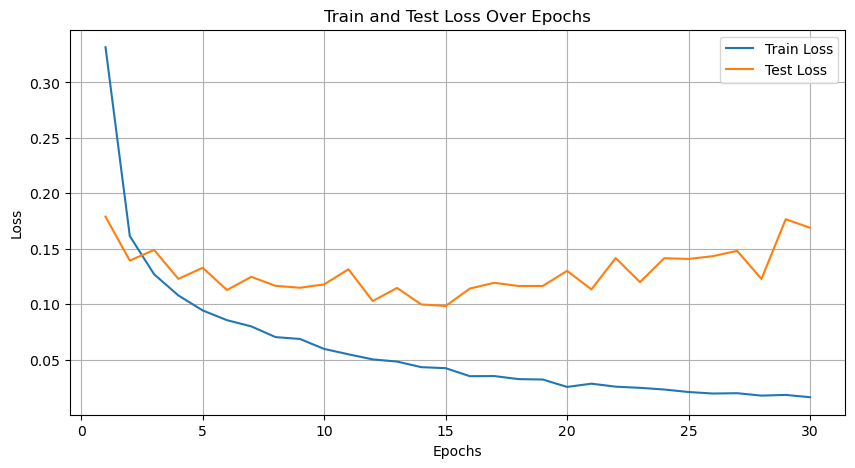

In [7]:
train_losses = []
test_losses = []

epochs = 30
for epoch in range(epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Take a peek at what the Gegenbauer Polynomials look like

In [8]:
def gegenbauer_polynomials(x, degree, alpha):
    if degree == 0:
        return np.ones_like(x)
    elif degree == 1:
        return 2 * alpha * x  # Corrected to follow C_1^alpha(x) = 2 * alpha * x

    # Initial values for C_0^alpha(x) and C_1^alpha(x)
    Pn_2 = np.ones_like(x)  # C_0^alpha(x)
    Pn_1 = 2 * alpha * x    # C_1^alpha(x)
    Pn = None
    
    # Compute Gegenbauer polynomials using the recurrence relation
    for n in range(1, degree):  # Starting from 1 because C_0 and C_1 are already initialized
        Pn = (2 * (n + alpha) * x * Pn_1 - (n + 2 * alpha - 1) * Pn_2) / (n + 1)
        Pn_2, Pn_1 = Pn_1, Pn  # Update values for the next iteration

    return Pn



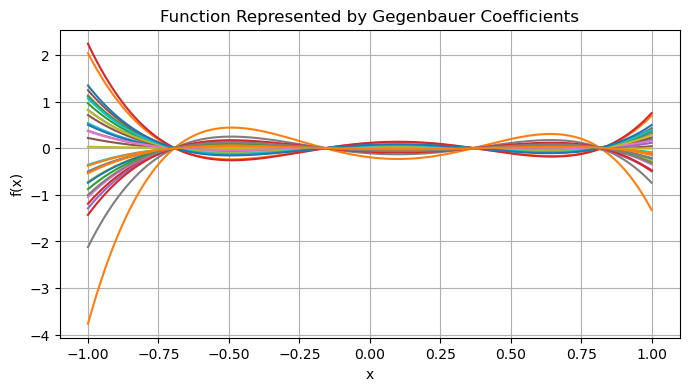

In [9]:
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.gegenbauerkan1.gegenbauer_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[28 * 28 // 2]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * gegenbauer_polynomials(x_values, i, alpha_)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Gegenbauer Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

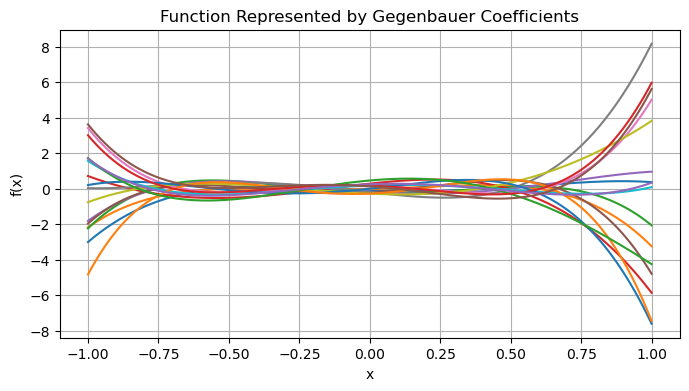

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.gegenbauerkan2.gegenbauer_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[16]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * gegenbauer_polynomials(x_values, i, alpha_)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Gegenbauer Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

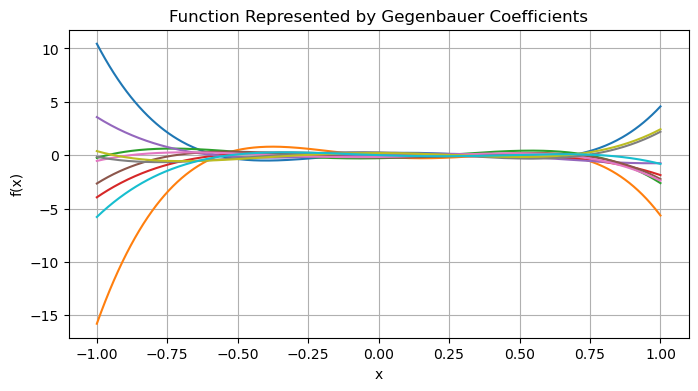

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
# choose the layer u want to inspect
all_coeffs = model.gegenbauerkan3.gegenbauer_coeffs.detach().cpu().numpy()
# choose the input dim
all_coeffs = all_coeffs[8]
# Plot over output dim
for some_coeffs in all_coeffs:
    x_values = np.linspace(-1, 1, 400)
    y_values = np.zeros_like(x_values)
    for i, coeff in enumerate(some_coeffs):
        y_values += coeff * gegenbauer_polynomials(x_values, i, alpha_)
    
    plt.plot(x_values, y_values)
    
plt.title('Function Represented by Gegenbauer Coefficients')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()